In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from sklearn.metrics import mean_squared_error as mse

from fastai.basic_train import Learner
from fastai.callbacks import OneCycleScheduler
from fastai.basic_data import DatasetType

from dies.data import ds_from_df_from_dtypes, scale_datasets, create_databunch, ds_from_df
from dies.data import train_test_split_dataset_with_test_date, train_test_split_dataset
from dies.autoencoder import Autoencoder
from dies.embedding import Embedding
from dies.utils_pytorch import dev_to_np, xavier_init_uniform

sns.set_context('poster')
sns.set_style('whitegrid')
mpl.rcParams["legend.loc"] = 'upper left'

In [2]:
with pd.HDFStore('./data/GEFCOM_Z1.h5') as store:
    df = store['powerdata']

In [3]:
df.head(2)

,AirPressure,Humidity,MaxPowerGeneration,PowerGeneration,Temperature,TimeUTC,WindDirectionMeridional100m,WindDirectionMeridional10m,WindDirectionZonal100m,WindDirectionZonal10m,WindSpeed100m,WindSpeed10m
0,NaN,NaN,1.0,0.000000,NaN,20120101 1:00,-3.666076,-2.681966,2.864280,2.124600,4.652334,3.421530
1,NaN,NaN,1.0,0.054879,NaN,20120101 2:00,-2.464761,-1.796960,3.344859,2.521695,4.154892,3.096451


Drop columns with na values

In [4]:
df = df.fillna(df.mean())

In [5]:
df = df.dropna(axis=1)

In [6]:
df.head(2)

,MaxPowerGeneration,PowerGeneration,TimeUTC,WindDirectionMeridional100m,WindDirectionMeridional10m,WindDirectionZonal100m,WindDirectionZonal10m,WindSpeed100m,WindSpeed10m
0,1.0,0.000000,20120101 1:00,-3.666076,-2.681966,2.864280,2.124600,4.652334,3.421530
1,1.0,0.054879,20120101 2:00,-2.464761,-1.796960,3.344859,2.521695,4.154892,3.096451


Create proper timestamp

In [7]:
df.TimeUTC = pd.to_datetime(df.TimeUTC, infer_datetime_format=True, utc=True)
df.set_index('TimeUTC', inplace=True)

In [8]:
df.PowerGeneration = df.PowerGeneration.apply(float) / df.MaxPowerGeneration.apply(float)
df.drop('MaxPowerGeneration', axis=1, inplace=True)

Create features for timeseries

In [9]:
df['DayOfYear'] = df.index.dayofyear
df['Hour'] = df.index.hour

In [10]:
df.columns

Index(['PowerGeneration', 'WindDirectionMeridional100m',
       'WindDirectionMeridional10m', 'WindDirectionZonal100m',
       'WindDirectionZonal10m', 'WindSpeed100m', 'WindSpeed10m', 'DayOfYear',
       'Hour'],
      dtype='object')

In [11]:
cols = [ 'WindDirectionMeridional100m',
       'WindDirectionMeridional10m', 'WindDirectionZonal100m',
       'WindDirectionZonal10m', 'WindSpeed100m', 'WindSpeed10m']

cat_cols = ['DayOfYear', 'Hour']
ds = ds_from_df(df, y_columns=cols, x_columns=cols, cat_columns = cat_cols)

Assure correct columns were selected. In case `x` and `y` are the same, we append `_target` for better separation.

In [12]:
ds.x_columns, ds.cat_columns, ds.y_columns

(['WindDirectionMeridional100m',
  'WindDirectionMeridional10m',
  'WindDirectionZonal100m',
  'WindDirectionZonal10m',
  'WindSpeed100m',
  'WindSpeed10m'],
 ['DayOfYear', 'Hour'],
 ['WindDirectionMeridional100m_target',
  'WindDirectionMeridional10m_target',
  'WindDirectionZonal100m_target',
  'WindDirectionZonal10m_target',
  'WindSpeed100m_target',
  'WindSpeed10m_target'])

In [13]:
ds_tr, ds_val, ds_te = train_test_split_dataset_with_test_date(ds, '2013-01-01')

We can use y_ranges to scale the output in the area of the output. Here, it doesn't make much sense, as the output is already normalized, and it is rather for demonstrating functionality.

In [14]:
y_ranges = ds_tr.y_ranges

Scale the input

In [15]:
scale_datasets(train_dataset=ds_tr, other_datasets=[ds_val, ds_te])

Create databunch for fastai training

In [16]:
db = create_databunch(ds_tr, ds_val, ds_te, batch_size=128, device='cpu')

Create MLP Model

In [17]:
input_size = ds_tr.x.shape[1]
sizes_cat = [ds_tr.cat[:,0].max()+1, ds_tr.cat[:,1].max()+1]
ann_structure = [10, 5]

In [18]:
embedding_module = Embedding(sizes_cat, embedding_dropout=0.1)
ann_model = Autoencoder(
    input_size=input_size,
    ann_structure=ann_structure,
    embedding_module=embedding_module,
    embeding_position="start",
    y_ranges=y_ranges,
)

 Train it

In [19]:
learn = Learner(
    db,
    ann_model,
    loss_func=torch.nn.MSELoss(),
)
cbs = [OneCycleScheduler(learn, lr_max=0.1)]

In [20]:
learn.fit(10, callbacks=cbs)

epoch,train_loss,valid_loss,time
0,7.776090,2.388544,00:00
1,2.598269,0.654777,00:00
2,1.256464,0.582403,00:00
3,0.857047,0.825785,00:00
4,0.655612,0.581915,00:00
5,0.506543,0.317993,00:00
6,0.412053,0.330848,00:00
7,0.370138,0.174852,00:00
8,0.320026,0.153605,00:00
9,0.292263,0.158614,00:00


Evaluation...Note, that through ```inverse_transform_input``` we can reverse the scaling of the input data.

In [21]:
df_test = ds_te.to_df(inverse_transform_input=True)
y_hat, _  = learn.get_preds(DatasetType.Test)
ws_idx = df_test.columns.get_loc("WindSpeed100m")
df_test['WindSpeed100mPred'] = y_hat[:, ws_idx]

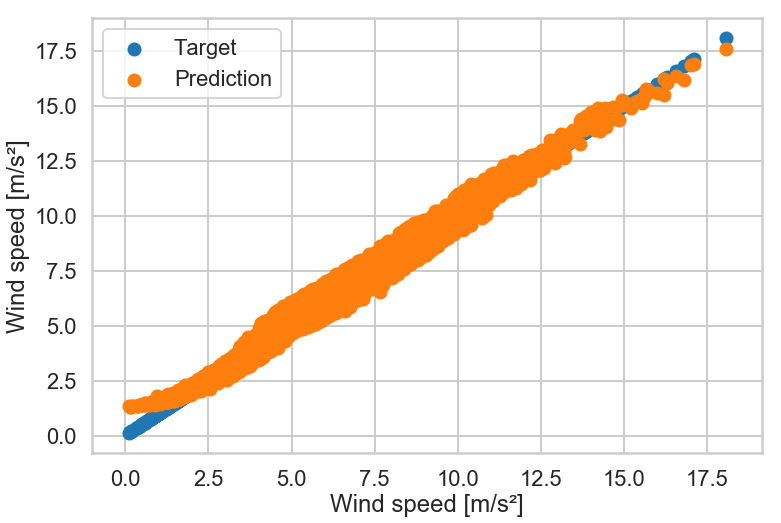

In [22]:
plt.figure(figsize=(12,8))
plt.scatter(df_test.WindSpeed100m, df_test.WindSpeed100m_target, label='Target')
plt.scatter(df_test.WindSpeed100m, df_test.WindSpeed100mPred, label='Prediction')
plt.xlabel('Wind speed [m/s²]')
plt.ylabel('Wind speed [m/s²]')
plt.legend()

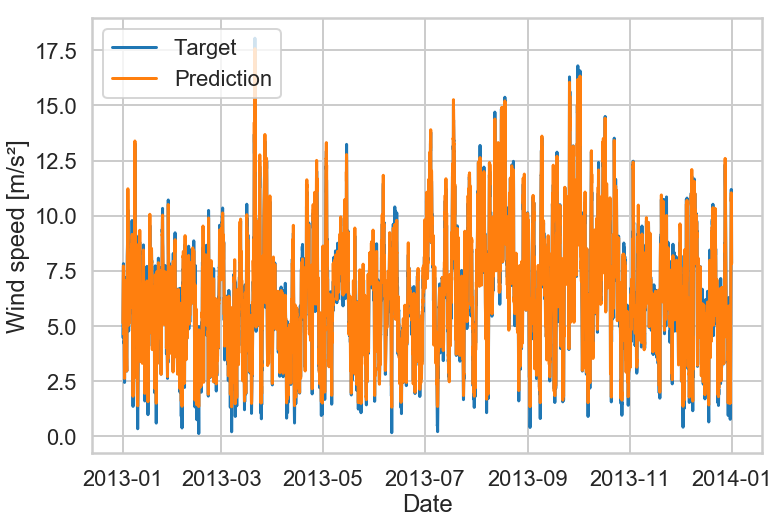

In [23]:
plt.figure(figsize=(12,8))
plt.plot(df_test.WindSpeed100m_target, label='Target')
plt.plot(df_test.WindSpeed100mPred, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Wind speed [m/s²]')
plt.legend()

In [25]:
print(f'Test RMSE for WindSpeed: {mse(df_test.WindSpeed100m_target, df_test.WindSpeed100mPred, squared=False)}')

Test RMSE for WindSpeed: 0.35677361488342285
